In [ ]:
import os
import sys

DATA_ROOT = "/home/guest/work/Datasets"

# get a list with all dirs on a given path
def get_dirs(path):
    if not os.path.exists(path):
        print(f"Path {path} does not exist.")
        sys.exit(1)
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# get a list with all files on a given path
def get_files(path):
    if not os.path.exists(path):
        print(f"Path {path} does not exist.")
        sys.exit(1)
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

In [ ]:
dirs = get_dirs(DATA_ROOT)
print(dirs)

next(os.walk(DATA_ROOT))[1]

['picai_labels-main', 'PI-CAI', 'picai_images_fold0']


In [ ]:
labels_orig_root  = os.path.join(DATA_ROOT, "picai_labels-main/csPCa_lesion_delineations/human_expert/original")
labels_resampled_root = os.path.join(DATA_ROOT, "picai_labels-main/csPCa_lesion_delineations/human_expert/resampled")
images_root = os.path.join(DATA_ROOT, "picai_images_fold0/")

# print len of dirs
len_imgs = len(get_dirs(images_root))
print(f"Number of files in {labels_orig_root}: {len(get_files(labels_orig_root))}")
print(f"Number of files in {labels_resampled_root}: {len(get_files(labels_resampled_root))}")
print(f"Number of directories in {images_root}: {len_imgs}")

Number of files in /home/guest/work/Datasets/picai_labels-main/csPCa_lesion_delineations/human_expert/original: 1295
Number of files in /home/guest/work/Datasets/picai_labels-main/csPCa_lesion_delineations/human_expert/resampled: 1295
Number of directories in /home/guest/work/Datasets/picai_images_fold0/: 295


> Every patient case will at least have three imaging sequences: axial T2W, axial DWI and axial ADC scans (i.e. files ending in _t2w.mha, _hbv.mha, _adc.mha). Additionally, they can also have either, both or none of these optional imaging sequences: sagittal and coronal T2W scans (i.e. files ending in _sag.mha, _cor.mha here). 

Vemos que algunos pacientes tienen imágenes adicionales

In [ ]:
dirs = get_dirs(images_root)

incomplete_dirs = []
for dir in dirs:
    # chechk if they all have 5 files
    dir_path = os.path.join(images_root, dir)
    files = get_files(dir_path)
    if len(files) != 5:
        print(f"Directory {dir} has {len(files)} files, expected 5.")
        incomplete_dirs.append(dir)
print(f"Number of non-matching directories: {len(incomplete_dirs)}")

print("Total file count excluding the previous non-matching: ", (len_imgs - len(incomplete_dirs) ) * 5)



Directory 10129 has 10 files, expected 5.
Directory 11383 has 10 files, expected 5.
Directory 10193 has 10 files, expected 5.
Directory 11087 has 10 files, expected 5.
Directory 10540 has 10 files, expected 5.
Number of non-matching directories: 5
Total file count excluding the previous non-matching:  1450


In [ ]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

def show_mha_image(image_path, save=False):
    """
    Opens and displays an image in .mha format.
    
    Parameters:
    -----------
    image_path : str
        Path to the .mha image file.
    """
    try:
        # Load the image using SimpleITK
        image = sitk.ReadImage(image_path)
        
        # Convert the image to a numpy array for visualization
        image_array = sitk.GetArrayViewFromImage(image)

        # Take a slice of the image (e.g., the middle slice)
        if image_array.ndim == 3:
            image_array = image_array[image_array.shape[0] // 2, :, :]
        elif image_array.ndim == 2:
            image_array = image_array[:, :]
        
        # Display the image using matplotlib
        plt.imshow(image_array, cmap='gray')
        plt.title(".mha Image")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error opening the image: {e}")


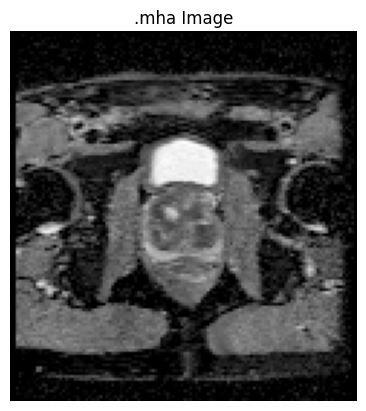

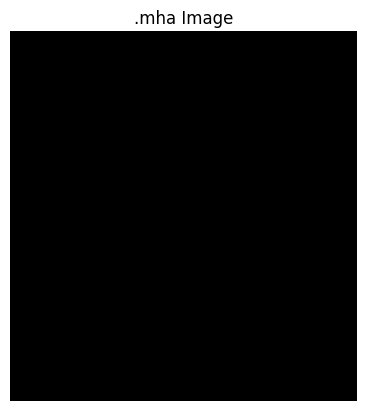

In [ ]:
import random

# pick a random folder and set the name of a file inside as the prefix
random_dir = random.choice(dirs)
files_in_dir = get_files(os.path.join(images_root, random_dir))
# pick a file ending with .mha and remove the extension for prefix
mha_files = [f for f in files_in_dir if f.endswith('.mha')]
if mha_files:
    prefix = f"{random_dir}/{mha_files[0][:13]}"
else:
    prefix = f"{random_dir}/{random_dir}_1000000"
#prefix = "10000/10000_1000000"

ruta = os.path.join(images_root, prefix + "_adc.mha")
show_mha_image(ruta)

ruta = os.path.join(labels_resampled_root, prefix.split("/")[1] + ".nii.gz")
show_mha_image(ruta)

Since the lesion annotations are provided for only a subset of the patients, we will only consider those patients for which lesion annotations are available.

In [ ]:
import SimpleITK as sitk

def count_and_find_non_empty_masks(folder):
    mask_files = get_files(folder)
    non_empty_count = 0
    non_empty_list = []
    for f in mask_files:
        path = os.path.join(folder, f)
        try:
            mask = sitk.ReadImage(path)
            arr = sitk.GetArrayViewFromImage(mask)
            if arr.max() > 0:
                non_empty_count += 1
                non_empty_list.append(f)
        except Exception as e:
            print(f"Error reading {f}: {e}")
    return non_empty_count, len(mask_files), non_empty_list

non_empty, total, non_empty_masks = count_and_find_non_empty_masks(labels_orig_root)
print(f"{non_empty} out of {total} masks are non-empty (contain a segmentation).")
print("Non-empty mask files:", non_empty_masks)

In [ ]:
# pick 10 non-empty mask files and show them and their respective images
sample_non_empty = random.sample(non_empty_masks, min(10, len(non_empty_masks)))
for mask_file in sample_non_empty:
    # Show mask
    mask_path = os.path.join(labels_orig_root, mask_file)
    print(f"Mask: {mask_file}")
    show_mha_image(mask_path)
    
    # Show corresponding image (assume prefix is first 13 chars of mask_file)
    prefix = mask_file[:13]
    # Try to find the corresponding image in images_root
    found = False
    for dir in dirs:
        image_path = os.path.join(images_root, dir, prefix + "_adc.mha")
        if os.path.exists(image_path):
            print(f"Image: {dir}/{prefix}_adc.mha")
            show_mha_image(image_path)
            found = True
            break
    if not found:
        print(f"No corresponding image found for mask {mask_file}")

In [ ]:
import numpy as np

# Choose a mask file (replace with your actual file if needed)
mask_file = os.path.join(labels_resampled_root, os.listdir(labels_resampled_root)[0])

# Load the mask
mask = sitk.ReadImage(mask_file)
mask_array = sitk.GetArrayViewFromImage(mask)

print(f"File: {mask_file}")
print(f"Shape (z, y, x): {mask_array.shape}")
print(f"Number of dimensions: {mask_array.ndim}")
print(f"Unique values in mask: {np.unique(mask_array)}")